### 🧩 Needed Imports


In [1]:
import os
import time
import joblib
import numpy as np
import pandas as pd
from lightgbm import LGBMRegressor
from matplotlib import pyplot as plt
from matplotlib.ticker import PercentFormatter
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

### Regression




In [5]:
def prepare_regression_dataset(csv_path, include_engineered: bool = False):
    df = pd.read_csv(csv_path)

    # Train only on tasks that are schedulable by exact RTA
    df_sched = df[df['schedulable'] == 1].copy()

    # Optional engineered features
    if include_engineered:
        df_sched['slack']      = df_sched['D'] - df_sched['C']
        df_sched['criticality']= df_sched['C'] / df_sched['D']
        df_sched['interference']= df_sched['C'] / df_sched['T']

    # Feature sets
    base_feats = ['C', 'D', 'T', 'inv_T', 'hp_util', 'U_total', 'n_tasks']
    eng_feats  = base_feats + ['slack', 'criticality', 'interference']
    feature_cols = eng_feats if include_engineered else base_feats

    X = df_sched[feature_cols]
    y = df_sched['R_true']

    return train_test_split(X, y, test_size=0.25, random_state=42)

In [6]:
def train_regressor(X_train, y_train, model_type, model_output_path=None):
    if model_output_path is None:
        model_output_path = f"../models/regression_models/{model_type}_regressor.pkl"

    if os.path.exists(model_output_path):
        print(f"📦 {model_type} already trained. Loading existing model.")
        return joblib.load(model_output_path), model_output_path

    if model_type == "linear_regression":
        model = LinearRegression()
        pipe  = Pipeline([('scaler', StandardScaler()), ('reg', model)])
    elif model_type == "random_forest":
        model = RandomForestRegressor(n_estimators=100, max_depth=12, n_jobs=-1, random_state=42)
        pipe  = Pipeline([('reg', model)])
    elif model_type == "xgboost":
        model = XGBRegressor(n_estimators=100, max_depth=6, n_jobs=-1, random_state=42)
        pipe  = Pipeline([('reg', model)])
    else:
        raise ValueError("Unsupported model type")

    pipe.fit(X_train, y_train)
    joblib.dump(pipe, model_output_path)
    print(f"Trained and saved model to {model_output_path}")
    return pipe, model_output_path

In [2]:
def evaluate_regressors(X_test, y_test, model_paths: dict):
    results = []
    plt.figure(figsize=(8, 6))

    for model_name, path in model_paths.items():
        pipe = joblib.load(path)
        y_pred = pipe.predict(X_test)

        mae   = mean_absolute_error(y_test, y_pred)
        rmse  = mean_squared_error(y_test, y_pred) ** 0.5
        r2    = r2_score(y_test, y_pred)
        max_e = np.max(np.abs(y_test - y_pred))
        under = (y_pred < y_test).mean() * 100

        results.append({"Model": model_name, "MAE": mae, "RMSE": rmse,
                        "R²": r2, "Max Error": max_e, "Underestimation %": under})

        plt.scatter(y_test, y_pred, s=5, alpha=0.3, label=f"{model_name} (R²={r2:.3f})")

        print(f"\n=== {model_name.upper()} REGRESSOR ===")
        print(f"MAE: {mae:.4f} | RMSE: {rmse:.4f} | R²: {r2:.4f} | "
              f"Max Error: {max_e:.2f} | Underestimation: {under:.2f}%")

    # identity line
    lo, hi = float(y_test.min()), float(y_test.max())
    plt.plot([lo, hi], [lo, hi], 'k--', label="Ideal Fit")
    plt.xlabel("True R_true")
    plt.ylabel("Predicted R_true")
    plt.title("True vs Predicted WCRT")
    plt.legend(loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()

    return pd.DataFrame(results).sort_values(by="R²", ascending=False)

Trained and saved model to ../models/regression_models/base_linear_regression.pkl
Trained and saved model to ../models/regression_models/base_random_forest.pkl
Trained and saved model to ../models/regression_models/base_xgboost.pkl
Trained and saved model to ../models/regression_models/eng_linear_regression.pkl
Trained and saved model to ../models/regression_models/eng_random_forest.pkl
Trained and saved model to ../models/regression_models/eng_xgboost.pkl

====== BASE FEATURES ======

=== LINEAR_REGRESSION REGRESSOR ===
MAE: 14.6403 | RMSE: 26.0961 | R²: 0.7925 | Max Error: 419.84 | Underestimation: 56.91%

=== RANDOM_FOREST REGRESSOR ===
MAE: 6.9407 | RMSE: 17.1596 | R²: 0.9103 | Max Error: 349.56 | Underestimation: 44.89%

=== XGBOOST REGRESSOR ===
MAE: 6.9562 | RMSE: 17.2447 | R²: 0.9094 | Max Error: 349.85 | Underestimation: 45.22%


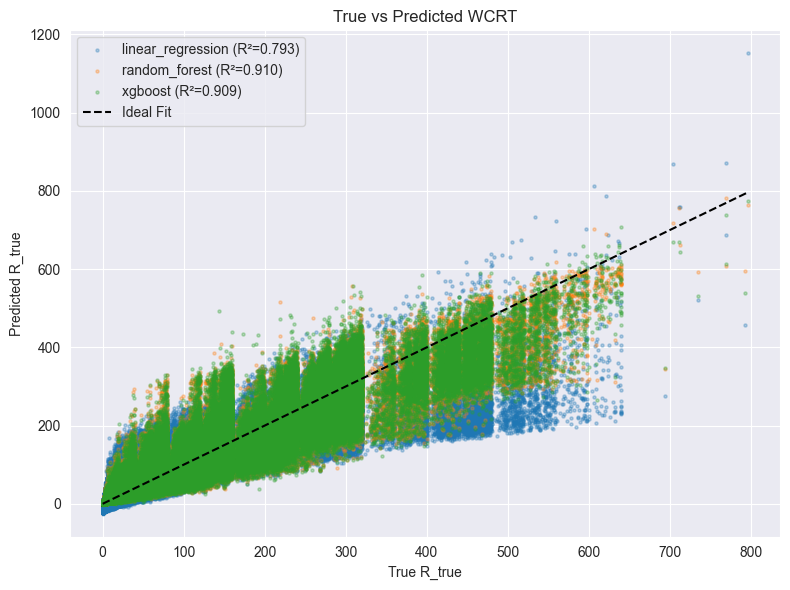


====== ENGINEERED FEATURES ======

=== LINEAR_REGRESSION REGRESSOR ===
MAE: 14.4229 | RMSE: 25.8555 | R²: 0.7964 | Max Error: 414.46 | Underestimation: 56.31%

=== RANDOM_FOREST REGRESSOR ===
MAE: 6.9420 | RMSE: 17.1623 | R²: 0.9103 | Max Error: 349.34 | Underestimation: 44.89%

=== XGBOOST REGRESSOR ===
MAE: 6.9327 | RMSE: 17.1557 | R²: 0.9103 | Max Error: 359.93 | Underestimation: 44.98%


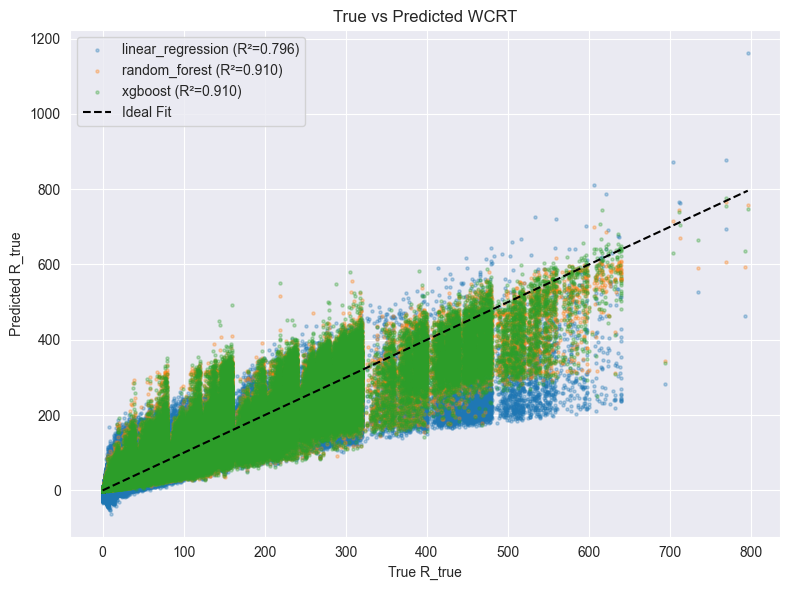


====== COMPARISON (Base vs Engineered) ======


,Feature Set,Model,MAE,RMSE,R²,Max Error,Underestimation %
2,Base,linear_regression,14.640323,26.096127,0.792547,419.843692,56.907202
5,Engineered,linear_regression,14.422853,25.855525,0.796355,414.456142,56.309385
0,Base,random_forest,6.940727,17.159574,0.910302,349.559421,44.888564
4,Engineered,random_forest,6.942045,17.162297,0.910274,349.342946,44.892522
1,Base,xgboost,6.956177,17.244674,0.909410,349.847186,45.217946
3,Engineered,xgboost,6.932652,17.155736,0.910342,359.925330,44.977455


In [8]:
# --- 1) Base vs Engineered feature splits -----------------------
Xb_train, Xb_test, yb_train, yb_test = prepare_regression_dataset(
    "../data/main_dataset.csv",
    include_engineered=False
)

Xe_train, Xe_test, ye_train, ye_test = prepare_regression_dataset(
    "../data/main_dataset.csv",
    include_engineered=True
)

# --- 2) Train three regressors for each feature set -------------
# Base features
train_regressor(Xb_train, yb_train, model_type="linear_regression",
                model_output_path="../models/regression_models/base_linear_regression.pkl")
train_regressor(Xb_train, yb_train, model_type="random_forest",
                model_output_path="../models/regression_models/base_random_forest.pkl")
train_regressor(Xb_train, yb_train, model_type="xgboost",
                model_output_path="../models/regression_models/base_xgboost.pkl")

# Engineered features
train_regressor(Xe_train, ye_train, model_type="linear_regression",
                model_output_path="../models/regression_models/eng_linear_regression.pkl")
train_regressor(Xe_train, ye_train, model_type="random_forest",
                model_output_path="../models/regression_models/eng_random_forest.pkl")
train_regressor(Xe_train, ye_train, model_type="xgboost",
                model_output_path="../models/regression_models/eng_xgboost.pkl")

# --- 3) Evaluate both sets (each call draws its own scatter) ----
print("\n====== BASE FEATURES ======")
res_base = evaluate_regressors(
    Xb_test, yb_test,
    {
        "linear_regression": "../models/regression_models/base_linear_regression.pkl",
        "random_forest":     "../models/regression_models/base_random_forest.pkl",
        "xgboost":           "../models/regression_models/base_xgboost.pkl",
    }
)

print("\n====== ENGINEERED FEATURES ======")
res_eng = evaluate_regressors(
    Xe_test, ye_test,
    {
        "linear_regression": "../models/regression_models/eng_linear_regression.pkl",
        "random_forest":     "../models/regression_models/eng_random_forest.pkl",
        "xgboost":           "../models/regression_models/eng_xgboost.pkl",
    }
)

# --- 4) Side-by-side comparison table ---------------------------
res_base.insert(0, "Feature Set", "Base")
res_eng.insert(0, "Feature Set", "Engineered")

comparison = pd.concat([res_base, res_eng], ignore_index=True)
comparison = comparison[["Feature Set", "Model", "MAE", "RMSE", "R²", "Max Error", "Underestimation %"]]
print("\n====== COMPARISON (Base vs Engineered) ======")
display(comparison.sort_values(["Model", "Feature Set"]))

# Optional: save tables for the dissertation artifacts
res_base.to_csv("../models/regression_models/results_base.csv", index=False)
res_eng.to_csv("../models/regression_models/results_engineered.csv", index=False)
comparison.to_csv("../models/regression_models/results_comparison.csv", index=False)


Loading trained model...
Analyzing underestimations...
Running margin sensitivity analysis...

🔍 COMPREHENSIVE UNDER-ESTIMATION ANALYSIS
Total Test Samples:               1,642,474
Underestimated Samples:             738,743 (44.98%)
Median Response Time:                  6.38
Median Underestimation (abs):          1.39
90th / 95th (abs):               21.5 /   38.3
Maximum Underestimation (abs):       359.93
Median / 90th / 95th (relative):  19.8% /  69.0% /  95.0%
Note: worst-case relative margin is dominated by occasional near-zero predictions; we therefore report relative percentiles rather than a '100% coverage' margin.

🛡️ MARGIN SENSITIVITY ANALYSIS
Best Achievable Coverage:      76.98% (at 20% margin)
Coverage at 10% Margin:        67.77%
Remaining Unsafe @10%:              529,406

Generating visualizations...


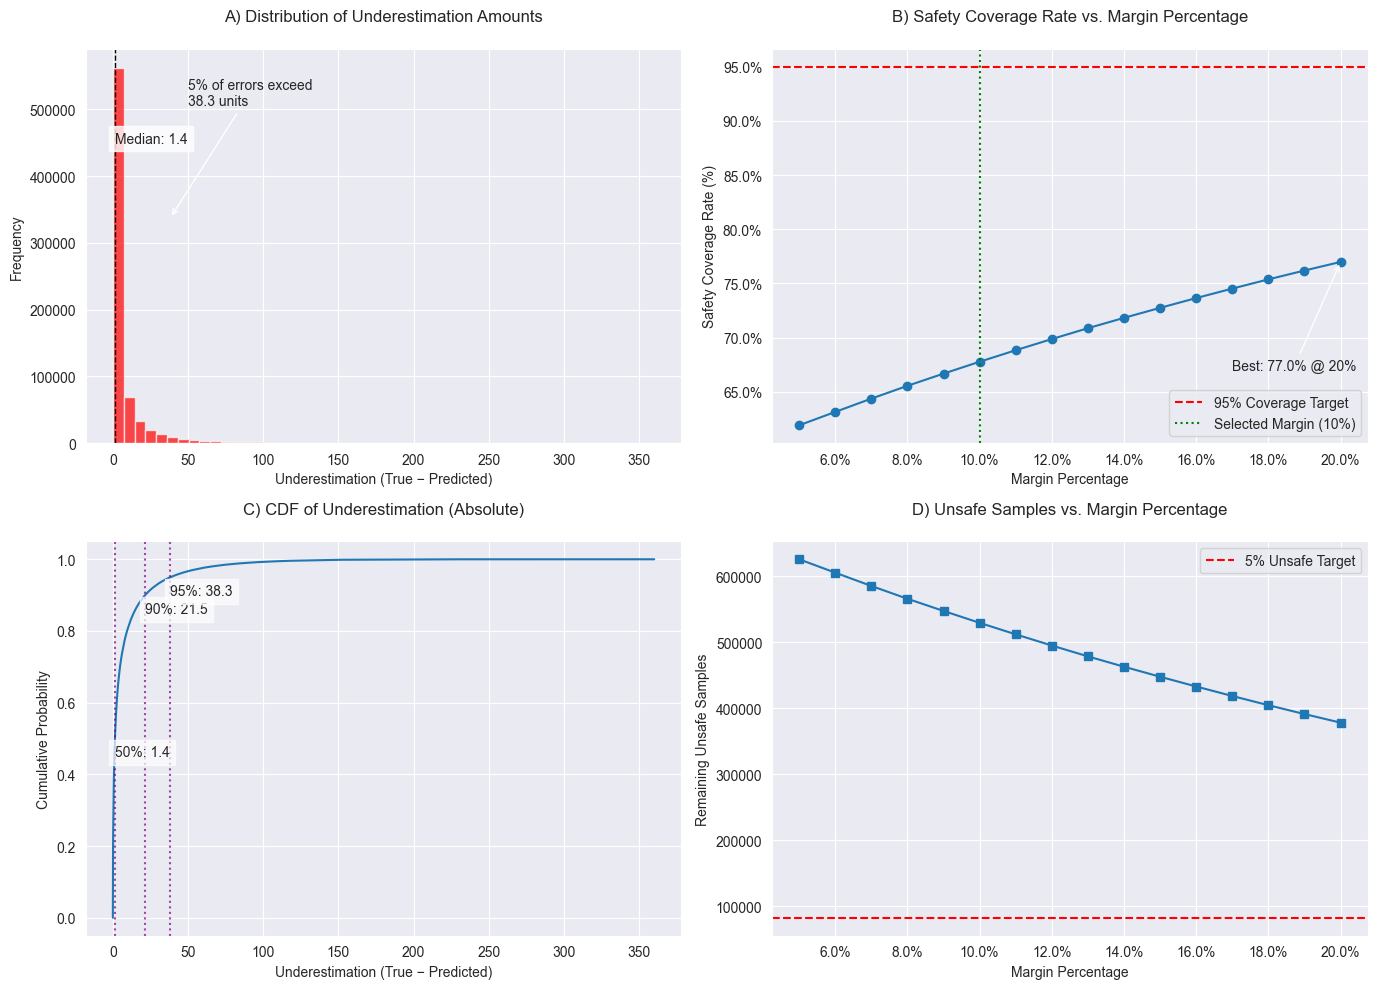

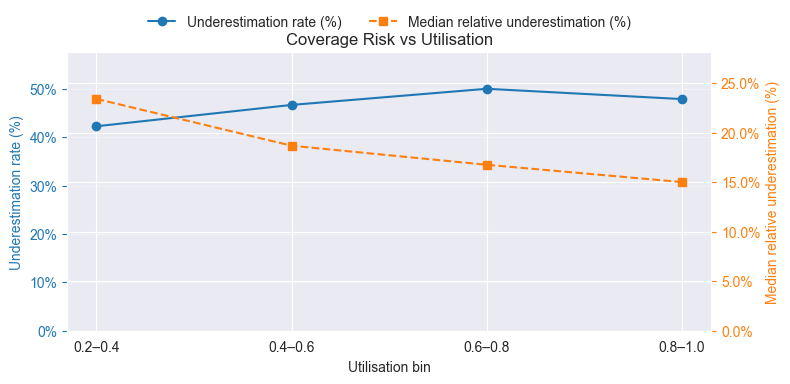

In [16]:
# --- 4.2.2 Error Distribution & Robustness (final) -----------------

# 1) Match model's feature set (engineered)
X_train, X_test, y_train, y_test = prepare_regression_dataset(
    "../data/main_dataset.csv", include_engineered=True
)

# 2) Load best baseline model (XGBoost with engineered features)
print("Loading trained model...")
xgb_pipeline = joblib.load("../models/regression_models/eng_xgboost.pkl")
y_pred = xgb_pipeline.predict(X_test)

# 3) Underestimation analysis (absolute + relative)
print("Analyzing underestimations...")
under_mask = y_pred < y_test
num_under = int(under_mask.sum())
pct_under = 100.0 * num_under / len(y_test)

under_abs = (y_test - y_pred)[under_mask]
# relative underestimation ratio r = (y - yhat)/yhat (guard tiny denom)
eps = 1e-9
under_rel = ((y_test - y_pred)[under_mask] / (y_pred[under_mask] + eps))

# absolute stats
median_resp  = float(np.median(y_test))
median_under = float(np.median(under_abs))
p90_under    = float(np.percentile(under_abs, 90))
p95_under    = float(np.percentile(under_abs, 95))
max_under    = float(np.max(under_abs))

# relative stats (this is what % margins act on)
median_rel = float(np.median(under_rel))        # e.g., 0.07 -> 7%
p90_rel    = float(np.percentile(under_rel, 90))
p95_rel    = float(np.percentile(under_rel, 95))
# max_rel = float(np.max(under_rel))            # computed but not reported (dominated by near-zero preds)

# 4) Margin sensitivity analysis
print("Running margin sensitivity analysis...")
margins = np.linspace(0.05, 0.20, 16)  # 5% to 20% in 1% increments
coverage_rates, remaining_unsafe = [], []
for m in margins:
    y_pred_m = y_pred * (1.0 + m)
    covered = (y_pred_m >= y_test)
    coverage_rates.append(100.0 * covered.mean())
    remaining_unsafe.append(int((~covered).sum()))

best_idx = int(np.argmax(coverage_rates))
best_cov = float(coverage_rates[best_idx])
best_mar = float(margins[best_idx])

selected_margin = 0.10
y_pred_10 = y_pred * (1.0 + selected_margin)
covered_10 = (y_pred_10 >= y_test)
pct_cov_10 = 100.0 * covered_10.mean()
remain_10  = int((~covered_10).sum())

# 5) Print concise summary (percentiles only for relative error)
print("\n" + "=" * 50)
print("🔍 COMPREHENSIVE UNDER-ESTIMATION ANALYSIS")
print("=" * 50)
print(f"{'Total Test Samples:':<30} {len(y_test):>12,}")
print(f"{'Underestimated Samples:':<30} {num_under:>12,} ({pct_under:.2f}%)")
print(f"{'Median Response Time:':<30} {median_resp:>12.2f}")
print(f"{'Median Underestimation (abs):':<30} {median_under:>12.2f}")
print(f"{'90th / 95th (abs):':<30} {p90_under:>6.1f} / {p95_under:>6.1f}")
print(f"{'Maximum Underestimation (abs):':<30} {max_under:>12.2f}")
print(f"{'Median / 90th / 95th (relative):':<30} {median_rel*100:>5.1f}% / {p90_rel*100:>5.1f}% / {p95_rel*100:>5.1f}%")
print("Note: worst-case relative margin is dominated by occasional near-zero predictions; "
      "we therefore report relative percentiles rather than a '100% coverage' margin.")

print("\n" + "=" * 50)
print("🛡️ MARGIN SENSITIVITY ANALYSIS")
print("=" * 50)
print(f"{'Best Achievable Coverage:':<30} {best_cov:.2f}% (at {best_mar:.0%} margin)")
print(f"{'Coverage at 10% Margin:':<30} {pct_cov_10:.2f}%")
print(f"{'Remaining Unsafe @10%:':<30} {remain_10:>12,}")

# 6) Figure 4.7 – Underestimation & margin sweep
print("\nGenerating visualizations...")
plt.figure(figsize=(14, 10))

# A) Histogram of absolute underestimation
plt.subplot(2, 2, 1)
n, bins, patches = plt.hist(under_abs, bins=50, color='red', alpha=0.7)
plt.title("A) Distribution of Underestimation Amounts", pad=20)
plt.xlabel("Underestimation (True − Predicted)")
plt.ylabel("Frequency")
ymax = max(n) if len(n) else 1
p95_val = np.percentile(under_abs, 95)
plt.annotate(f"5% of errors exceed\n{p95_val:.1f} units",
             xy=(p95_val, ymax*0.6), xytext=(p95_val*1.3, ymax*0.9),
             arrowprops=dict(arrowstyle="->"))
plt.axvline(median_under, color='k', linestyle='--', linewidth=1)
plt.text(median_under*1.05, ymax*0.8, f'Median: {median_under:.1f}',
         bbox=dict(facecolor='white', alpha=0.8))
plt.grid(True)

# B) Margin % vs coverage %
plt.subplot(2, 2, 2)
plt.plot(margins, coverage_rates, marker='o', linestyle='-')
plt.axhline(95, color='r', linestyle='--', label='95% Coverage Target')
plt.axvline(selected_margin, color='g', linestyle=':', label='Selected Margin (10%)')
plt.title("B) Safety Coverage Rate vs. Margin Percentage", pad=20)
plt.xlabel("Margin Percentage"); plt.ylabel("Safety Coverage Rate (%)")
plt.gca().yaxis.set_major_formatter(PercentFormatter())
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.annotate(f"Best: {best_cov:.1f}% @ {best_mar:.0%}",
             xy=(best_mar, best_cov), xytext=(best_mar-0.03, best_cov-10),
             arrowprops=dict(arrowstyle="->"))
plt.legend(); plt.grid(True)

# C) CDF of absolute underestimation
plt.subplot(2, 2, 3)
sorted_abs = np.sort(under_abs)
cdf = np.linspace(0, 1, len(sorted_abs))
plt.plot(sorted_abs, cdf)
plt.title("C) CDF of Underestimation (Absolute)", pad=20)
plt.xlabel("Underestimation (True − Predicted)"); plt.ylabel("Cumulative Probability")
for p, val in [(0.5, median_under), (0.9, p90_under), (0.95, p95_under)]:
    plt.axvline(val, color='purple', linestyle=':', alpha=0.7)
    plt.text(val, p-0.05, f'{int(p*100)}%: {val:.1f}', bbox=dict(facecolor='white', alpha=0.7))
plt.grid(True)

# D) Remaining unsafe vs margin
plt.subplot(2, 2, 4)
plt.plot(margins, remaining_unsafe, marker='s')
plt.title("D) Unsafe Samples vs. Margin Percentage", pad=20)
plt.xlabel("Margin Percentage"); plt.ylabel("Remaining Unsafe Samples")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.axhline(y=len(y_test)*0.05, color='r', linestyle='--', label='5% Unsafe Target')
plt.legend(); plt.grid(True)

plt.tight_layout()
plt.savefig('../figures/underestimation_analysis.png', dpi=300)
plt.show()

# 7) Figure 4.8 – Stratified risk by utilisation (polished)
if 'U_total' in X_test.columns:
    df_eval = X_test.copy()
    df_eval["true_R"] = y_test.values
    df_eval["pred_R"] = y_pred
    df_eval["under"]  = under_mask.values

    # relative underestimation already computed as `under_rel` for underestimates:
    df_eval["rel_under"] = 0.0
    df_eval.loc[under_mask, "rel_under"] = under_rel

    util_bins = [0.2, 0.4, 0.6, 0.8, 1.0]
    labels    = ["0.2–0.4", "0.4–0.6", "0.6–0.8", "0.8–1.0"]
    df_eval["util_bin"] = pd.cut(df_eval["U_total"], bins=util_bins, labels=labels, include_lowest=True)

    # Median only over underestimates (others -> NaN)
    df_eval["rel_under_masked"] = df_eval["rel_under"].where(df_eval["under"], np.nan)

    grp = (df_eval.groupby("util_bin", observed=True)
                  .agg(under_rate=("under", "mean"),
                       median_rel_under=("rel_under_masked", "median"))
                  .reset_index())
    grp["median_rel_under"] = grp["median_rel_under"].fillna(0.0)

    # ---- Plot (clear legend, matching axis colors, better limits) ----
    plt.figure(figsize=(8, 4))
    ax1 = plt.gca()
    x_vals = grp["util_bin"].astype(str)

    # Blue: underestimation rate (left y-axis, %)
    l1, = ax1.plot(x_vals, grp["under_rate"] * 100, marker='o',
                   color='tab:blue', label="Underestimation rate (%)")
    ax1.set_xlabel("Utilisation bin")
    ax1.set_ylabel("Underestimation rate (%)", color='tab:blue')
    ax1.yaxis.set_major_formatter(PercentFormatter())
    ax1.tick_params(axis='y', colors='tab:blue')
    ax1.grid(True, axis='y', alpha=0.3)
    ax1.set_ylim(0, (grp["under_rate"]*100).max() * 1.15)
    ax1.margins(x=0.05)

    # Orange: median relative underestimation among underestimates (right y-axis, %)
    ax2 = ax1.twinx()
    l2, = ax2.plot(x_vals, grp["median_rel_under"] * 100, marker='s', linestyle='--',
                   color='tab:orange', label="Median relative underestimation (%)")
    ax2.set_ylabel("Median relative underestimation (%)", color='tab:orange')
    ax2.yaxis.set_major_formatter(PercentFormatter())
    ax2.tick_params(axis='y', colors='tab:orange')
    ax2.set_ylim(0, (grp["median_rel_under"]*100).max() * 1.20)

    # One legend above the plot
    lines = [l1, l2]
    labels_ = [ln.get_label() for ln in lines]
    ax1.legend(lines, labels_, loc='upper center', bbox_to_anchor=(0.5, 1.18),
               ncol=2, frameon=False)

    plt.title("Coverage Risk vs Utilisation")
    plt.tight_layout()
    plt.savefig("../figures/error_stratification.png", dpi=300)
    plt.show()




# 8) Save table values for the dissertation (Table 4.5)
pd.DataFrame([{
    "Underestimation rate (%)": pct_under,
    "Median underestimation (abs)": median_under,
    "90th / 95th (abs)": f"{p90_under:.1f} / {p95_under:.1f}",
    "Max underestimation (abs)": max_under,
    "Median / 90th / 95th (rel %)": f"{median_rel*100:.1f} / {p90_rel*100:.1f} / {p95_rel*100:.1f}",
    "Coverage @10% margin (%)": pct_cov_10,
    "Best coverage in [5,20]% (%)": best_cov
}]).to_csv("../results/table_4_5_underestimation_stats.csv", index=False)


CQR (95%) — Test Metrics
Coverage: 94.97%
Avg interval width: 31.35
Max interval width: 519.33
Midpoint MAE: 7.6732
Midpoint Max Abs Error: 373.3166


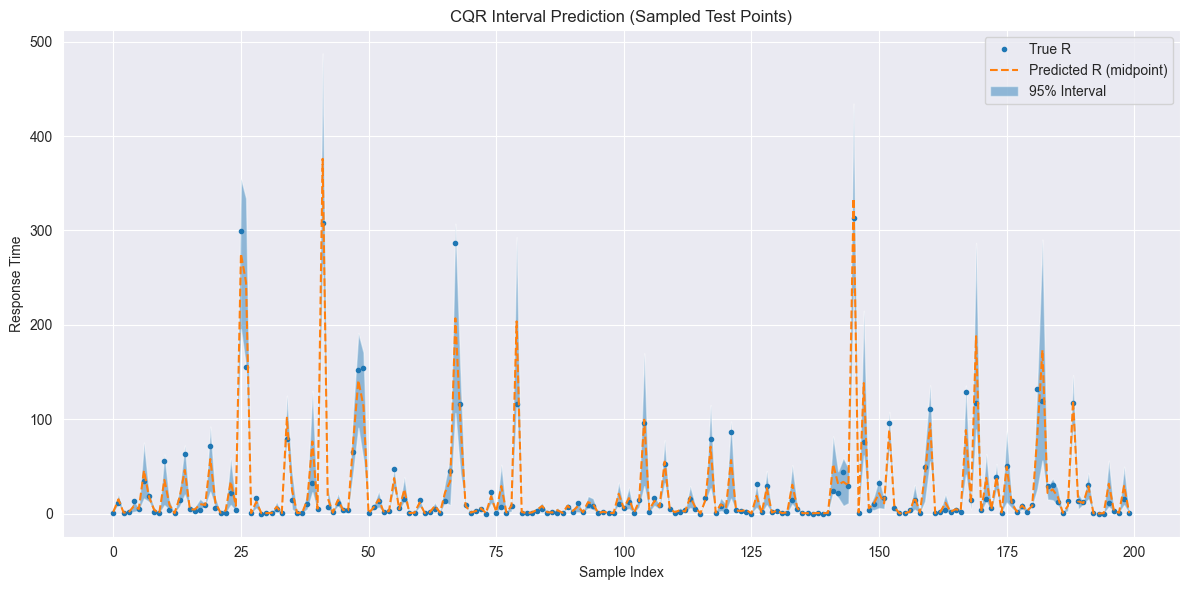

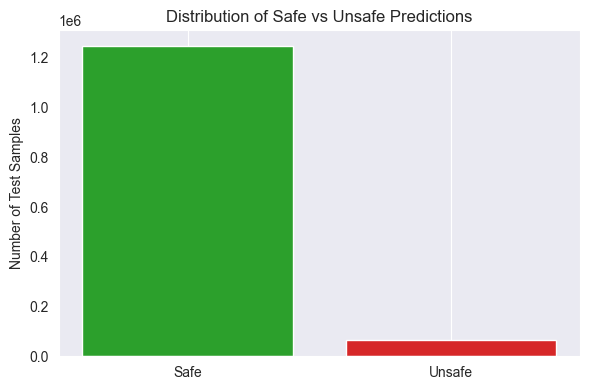

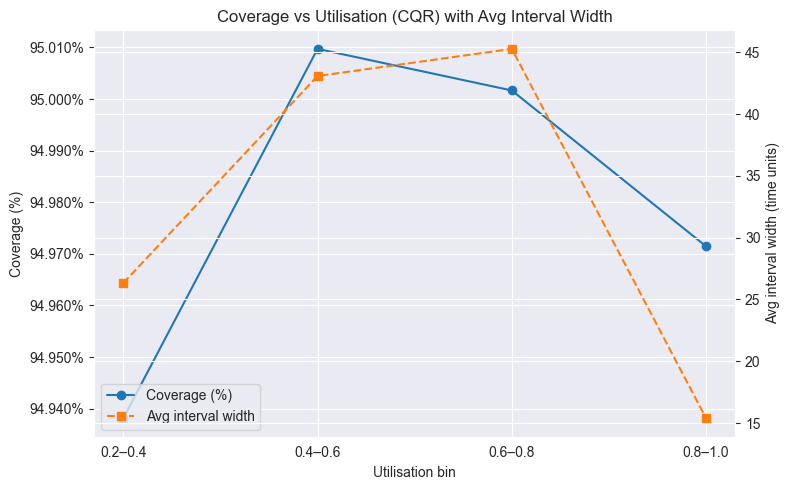


Finished in 63.50s.


In [19]:
ALPHA = 0.05  # 95% nominal coverage

def add_rt_features(df):
    df = df.copy()
    df['C_div_T']    = df['C'] / df['T']
    df['slack']      = df['D'] - df['C']
    df['criticality']= df['C'] / df['D']
    df['interference']= df['C'] / df['T']
    df['C_squared']  = df['C'] ** 2
    df['T_over_D']   = df['T'] / df['D']
    df['interaction']= df['C'] * df['hp_util']
    return df

def train_quantile_model(X, y, alpha, model_path):
    if os.path.exists(model_path):
        return joblib.load(model_path)
    model = LGBMRegressor(objective='quantile', alpha=alpha,
                          num_leaves=31, min_data_in_leaf=20,
                          learning_rate=0.05, n_estimators=500,
                          reg_alpha=0.1, reg_lambda=0.1, n_jobs=-1, verbose=-1)
    model.fit(X, y)
    joblib.dump(model, model_path)
    return model

def adaptive_calibration(Xc, yc, qlo_c, qhi_c, alpha):
    # conformity score: max(q_lo(x)-y, y-q_hi(x))  (>=0)
    scores = np.maximum(qlo_c - yc, yc - qhi_c)
    bins = np.quantile(Xc['U_total'], [0.0, 0.5, 1.0])  # 2 utilisation bins
    bin_idx = np.digitize(Xc['U_total'], bins)          # 1..len(bins)
    q_vals, keys = [], sorted(np.unique(bin_idx))
    for b in keys:
        s = scores[bin_idx == b]
        q_vals.append(np.quantile(s, 1 - alpha, method='higher') if len(s) else 0.0)
    return bins, dict(zip(keys, q_vals))

# ---- Pipeline ----
t0 = time.time()
df = pd.read_csv("../data/main_dataset.csv")
df = df[df['schedulable'] == 1]
df = add_rt_features(df)

features = ['C','D','T','inv_T','hp_util','U_total','n_tasks',
            'C_div_T','slack','criticality','interference',
            'C_squared','T_over_D','interaction']
X, y = df[features], df['R_true']

X_tr, X_tmp, y_tr, y_tmp = train_test_split(
    X, y, test_size=0.40,
    stratify=pd.qcut(X['U_total'], 5, duplicates='drop'), random_state=42
)
X_cal, X_te, y_cal, y_te = train_test_split(
    X_tmp, y_tmp, test_size=0.50,
    stratify=pd.qcut(X_tmp['U_total'], 5, duplicates='drop'), random_state=42
)

lo_model = train_quantile_model(X_tr, y_tr, ALPHA/2, "../models/regression_models/cqr_lower_model.pkl")
hi_model = train_quantile_model(X_tr, y_tr, 1-ALPHA/2, "../models/regression_models/cqr_upper_model.pkl")

# Calibration
qlo_cal = lo_model.predict(X_cal)
qhi_cal = hi_model.predict(X_cal)
bins, q_by_bin = adaptive_calibration(X_cal, y_cal.values, qlo_cal, qhi_cal, ALPHA)

# Test predictions + calibrated intervals
qlo_te = lo_model.predict(X_te)
qhi_te = hi_model.predict(X_te)
test_bin = np.digitize(X_te['U_total'], bins)
q_add = np.array([q_by_bin.get(b, 0.0) for b in test_bin])
L = qlo_te - q_add
U = qhi_te + q_add
mid = (L + U) / 2.0

# Metrics
covered = (y_te.values >= L) & (y_te.values <= U)
coverage = covered.mean() * 100.0
widths = U - L
avg_width = float(np.mean(widths))
max_width = float(np.max(widths))
mae_mid = float(mean_absolute_error(y_te, mid))
max_abs_err_mid = float(np.max(np.abs(y_te - mid)))

print("\nCQR (95%) — Test Metrics")
print(f"Coverage: {coverage:.2f}%")
print(f"Avg interval width: {avg_width:.2f}")
print(f"Max interval width: {max_width:.2f}")
print(f"Midpoint MAE: {mae_mid:.4f}")
print(f"Midpoint Max Abs Error: {max_abs_err_mid:.4f}")

# Figure 4.9 — 200-sample intervals
plt.figure(figsize=(12, 6))
idx = np.arange(200)
plt.plot(y_te.values[:200], label="True R", marker='o', markersize=3, linestyle='')
plt.plot(mid[:200], label="Predicted R (midpoint)", linestyle='--')
plt.fill_between(idx, L[:200], U[:200], alpha=0.45, label="95% Interval")
plt.xlabel("Sample Index"); plt.ylabel("Response Time")
plt.title("CQR Interval Prediction (Sampled Test Points)")
plt.legend(); plt.grid(True); plt.tight_layout()
plt.savefig("improved_cqr_plot.png", dpi=300); plt.show()

# Safe vs Unsafe bar (optional)
safe_cnt = int(covered.sum()); unsafe_cnt = int((~covered).sum())
plt.figure(figsize=(6,4))
plt.bar(["Safe","Unsafe"], [safe_cnt, unsafe_cnt], color=["tab:green","tab:red"])
plt.title("Distribution of Safe vs Unsafe Predictions")
plt.ylabel("Number of Test Samples"); plt.grid(axis='y'); plt.tight_layout()
plt.savefig("safety_distribution.png", dpi=300); plt.show()

# Figure 4.10 — Coverage vs utilisation (+ avg width)
df_eval = X_te.copy()
df_eval["covered"] = covered
df_eval["width"] = widths

util_bins = [0.2, 0.4, 0.6, 0.8, 1.0]
labels = ["0.2–0.4","0.4–0.6","0.6–0.8","0.8–1.0"]
df_eval["util_bin"] = pd.cut(df_eval["U_total"], util_bins, labels=labels, include_lowest=True)

cov_by_bin = (df_eval.groupby("util_bin", observed=True)
              .agg(coverage=("covered","mean"), avg_width=("width","mean"))
              .reset_index())

plt.figure(figsize=(8,5))
ax1 = plt.gca()
ax1.plot(cov_by_bin["util_bin"].astype(str), cov_by_bin["coverage"]*100,
         marker='o', label="Coverage (%)")
ax1.set_ylabel("Coverage (%)"); ax1.set_xlabel("Utilisation bin")
ax1.yaxis.set_major_formatter(PercentFormatter()); ax1.grid(True)

ax2 = ax1.twinx()
ax2.plot(cov_by_bin["util_bin"].astype(str), cov_by_bin["avg_width"],
         marker='s', linestyle='--', color='tab:orange', label="Avg interval width")
ax2.set_ylabel("Avg interval width (time units)")

lines = [ax1.get_lines()[0], ax2.get_lines()[0]]
ax1.legend(lines, [l.get_label() for l in lines], loc="lower left")
plt.title("Coverage vs Utilisation (CQR) with Avg Interval Width")
plt.tight_layout()
plt.savefig("coverage_vs_util.png", dpi=300); plt.show()